# 5. Pretraining on unlabeled data

In [1]:
import torch
import tiktoken
from previous_chapter import GPTModel, generate_text_simple

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval(); 

In [2]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # unsqueeze(0) adds the batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # squeeze(0) removes batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(model=model, idx=text_to_token_ids(start_context, tokenizer), max_new_tokens=10, context_size=GPT_CONFIG_124M["context_length"])
print(token_ids.shape)
print("Output text: \n", token_ids_to_text(token_ids, tokenizer))

torch.Size([1, 14])
Output text: 
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


### 5.1.2 Calculating the text generation loss

In [3]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

In [4]:
with torch.no_grad():
    logits = model(inputs)
probas = torch.softmax(logits, dim=-1)
print(logits.shape)

torch.Size([2, 3, 50257])


In [5]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print(token_ids)

tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [6]:
print("Targets batch 1: ", token_ids_to_text(targets[0], tokenizer))
print("Outputs batch 1: ", token_ids_to_text(token_ids[0].flatten(), tokenizer))

print("Targets batch 2: ", token_ids_to_text(targets[1], tokenizer))
print("Outputs batch 2: ", token_ids_to_text(token_ids[1].flatten(), tokenizer))

Targets batch 1:   effort moves you
Outputs batch 1:   Armed heNetflix
Targets batch 2:   really like chocolate
Outputs batch 2:   pressuring empoweredfaith


In [7]:
target_probas_1 = probas[0, [0,1,2], targets[0]]
target_probas_2 = probas[1, [0,1,2], targets[1]]
print(target_probas_1)
print(target_probas_2)
# print(probas[0, :, targets[0]])
# print(targets[0])
# print(targets.shape, probas.shape)

tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


In [8]:
print(torch.cat((target_probas_1, target_probas_2)))

log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
avg_log_probas = torch.mean(log_probas)
neg_avg_log_probas = avg_log_probas * -1

print(log_probas)
print(avg_log_probas)
print(neg_avg_log_probas)

tensor([7.4541e-05, 3.1061e-05, 1.1563e-05, 1.0337e-05, 5.6776e-05, 4.7559e-06])
tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])
tensor(-10.7940)
tensor(10.7940)


In [9]:
print("Logits shape:", logits.shape)
print("Targets shape:", targets.shape)

logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten(0, 1)

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)
perplexity = torch.exp(loss)
print(perplexity) 
# Perplexity translate to the model being unsure about which among 48725 tokens in vocabulary to generates as the next token

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])
Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])
tensor(10.7940)
tensor(48725.8203)


### 5.1.3 Calculating the training and validation set losses

In [10]:
file_path = "the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

total_characters = len(text_data)
total_token = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_token)


Characters: 20479
Tokens: 5145


In [11]:
train_ratio = 0.9
split_idx = int(train_ratio * total_characters)
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [12]:
from previous_chapter import create_dataloader_v1
torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0,
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0,
)

In [13]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [14]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

In [15]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else: 
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

device = torch.device("xpu" if torch.xpu.is_available() else "cpu")
print("Using device", device)
model.to(device)
torch.manual_seed(123)
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)


Using device xpu
Training loss: 10.98758316040039
Validation loss: 10.98110580444336


## 5.2 Training an LLM

In [16]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [17]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(model=model, idx=encoded, max_new_tokens=50, context_size=context_size)
    
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()

In [18]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step +=1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): Train Loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        generate_and_print_sample(model, tokenizer, device, start_context)
    
    return train_losses, val_losses, track_tokens_seen

In [19]:
# Note:
# Uncomment the following code to calculate the execution time
# import time
# start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr= 0.0004, weight_decay=0.1)
num_epoch = 10
train_losses, val_losses, tokens_seen = train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs=num_epoch, eval_freq=5, eval_iter=5, start_context="Every effort moves you", tokenizer=tokenizer)

# Note:
# Uncomment the following code to show the execution time
# end_time = time.time()
# execution_time_minutes = (end_time - start_time) / 60
# print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train Loss 9.818, Val loss 9.923
Ep 1 (Step 000005): Train Loss 8.066, Val loss 8.334
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train Loss 6.619, Val loss 7.044
Ep 2 (Step 000015): Train Loss 6.040, Val loss 6.595
Every effort moves you, and,, and,,,,,,, and,.                                   
Ep 3 (Step 000020): Train Loss 5.523, Val loss 6.499
Ep 3 (Step 000025): Train Loss 5.399, Val loss 6.374
Every effort moves you, and to the of the of the picture to the picture.                                     
Ep 4 (Step 000030): Train Loss 4.861, Val loss 6.254
Ep 4 (Step 000035): Train Loss 4.632, Val loss 6.277
Every effort moves you of the picture.                        "I"I the picture"I had the picture"I the picture and I had been the picture of
Ep 5 (Step 000040): Train Loss 3.988, Val loss 6.152
Every effort moves you know he had been his pictures--his his pictures--I had been.                                  

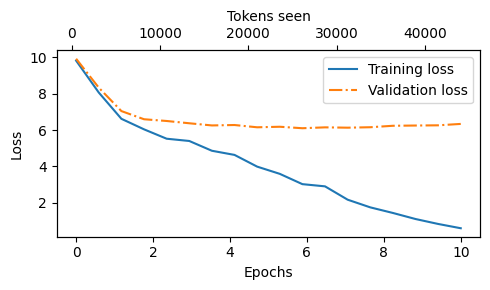

In [20]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

epoch_tensor = torch.linspace(0, num_epoch, len(train_losses))
plot_losses(epoch_tensor, tokens_seen, train_losses, val_losses)

## 5.3 Decoding strategies to control randomness

In [21]:
model.to("cpu")
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(model=model, idx=text_to_token_ids("Every effort moves you", tokenizer), max_new_tokens=25, context_size=GPT_CONFIG_124M["context_length"])
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




In [22]:
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 

inverse_vocab = {v: k for k, v in vocab.items()}

# Suppose input is "every effort moves you", and the LLM
# returns the following logits for the next token:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()

# The next generated token is then as follows:
print(inverse_vocab[next_token_id])

torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for _ in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)


forward
toward
71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


In [23]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

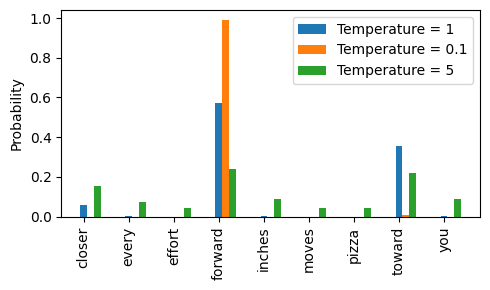

In [24]:
temperatures = [1, 0.1, 5]
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

x = torch.arange(len(vocab))
bar_widht = 0.15
fig, ax = plt.subplots(figsize=(5,3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x+i*bar_widht, scaled_probas[i], bar_widht, label=f"Temperature = {T}")
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

### Excercise 5.1

In [25]:
for t in temperatures:
    probas = softmax_with_temperature(next_token_logits, t)
    print("Temperature", t)
    print_sampled_tokens(probas)
    print()

Temperature 1
71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you

Temperature 0.1
0 x closer
0 x every
0 x effort
992 x forward
0 x inches
0 x moves
0 x pizza
8 x toward

Temperature 5
153 x closer
68 x every
55 x effort
223 x forward
102 x inches
50 x moves
43 x pizza
218 x toward
88 x you



### 5.3.2 Top-k Sampling

In [26]:
top_k = 3
top_logits, top_poss = torch.topk(next_token_logits, top_k)
print(top_logits)
print(top_poss)

new_logits = torch.where(
    condition=next_token_logits < top_logits[-1], 
    input=torch.tensor(float('-inf')), 
    other=next_token_logits
    )
print(new_logits)
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)
print(torch.softmax(top_logits, dim=0))

tensor([6.7500, 6.2800, 4.5100])
tensor([3, 7, 0])
tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])
tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])
tensor([0.5775, 0.3610, 0.0615])


### 5.3.3 Modifying the text generation function

In [27]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        if top_k is not None:
            top_logits, top_poss = torch.topk(logits, top_k)
            # print(top_logits, top_poss)
            logits = torch.where(logits < top_logits[:, -1], torch.tensor(float('-inf')).to(idx.device), logits)
        if temperature > 0.0:
            logits /= temperature
            probs = torch.softmax(logits, dim=-1)
            # print(probs[0, :5])
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        if idx_next == eos_id:
            break
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [28]:
torch.manual_seed(123)
tokens_ids = generate(
    model=model, 
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M['context_length'],
    top_k=1,
    temperature=100,
)

print(token_ids_to_text(tokens_ids, tokenizer))

Every effort moves you?"

"Yes--quite insensible to the irony. She wanted


## 5.4 Loading and saving model weights in PyTorch

In [29]:
torch.save(model.state_dict(), "model.pth")

In [30]:
# model = GPTModel(GPT_CONFIG_124M)
# model.load_state_dict(torch.load("model.pth", map_location=device, weights_only=True))
# model.eval()

In [31]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),        
    },
    "model_and_optimizer.pth"
)

checkpoint = torch.load("model_and_optimizer.pth", map_location=device)
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train()

C:\Users\IdeaPad\AppData\Local\Temp\ipykernel_11016\4225352625.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("model_and_optimizer.pth", map_loc

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

## 5.5 Loading pretrained weights from OpenAI

In [32]:
from gpt_download import download_and_load_gpt2

settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 38.5kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 693kiB/s] 
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 45.1kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [06:21<00:00, 1.30MiB/s]  
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 2.61MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:00<00:00, 486kiB/s] 
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 543kiB/s] 


In [34]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())
print(params["wte"].shape)

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])
(50257, 768)


In [35]:
# Define model configurations in a dictionary for compactness
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# Copy the base configuration and update with specific model settings
model_name = "gpt2-small (124M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

gpt = GPTModel(NEW_CONFIG)
gpt.eval();

In [36]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [59]:
print(len(params["blocks"]))
print(len(params["blocks"][0]))
print(params["blocks"][0].keys())
print(params["blocks"][0]["attn"].keys())
print(params["blocks"][0]["attn"]["c_attn"].keys())
print(params["blocks"][0]["attn"]["c_attn"]["w"].shape)
q_w, k_w, v_w = np.split(params["blocks"][0]["attn"]["c_attn"]["w"], 3, axis=-1)
print(q_w.shape, k_w.shape, v_w.shape)

12
4
dict_keys(['attn', 'ln_1', 'ln_2', 'mlp'])
dict_keys(['c_attn', 'c_proj'])
dict_keys(['b', 'w'])
(768, 2304)
(768, 768) (768, 768) (768, 768)


In [60]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])
    
    
load_weights_into_gpt(gpt, params)
gpt.to(device);

In [63]:
torch.manual_seed(123)
token_ids = generate(
    model=gpt,
    idx = text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you as far as the hand can go until the end of your turn unless something happens

This would remove you from a battle


## Excercise 5.5

In [64]:
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, gpt, device)
    val_loss = calc_loss_loader(val_loader, gpt, device)
print(train_loss, val_loss)

3.7547627025180392 3.559633493423462


## Exercise 5.6

In [66]:
# Copy the base configuration and update with specific model settings
model_name = "gpt2-medium (355M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

gpt = GPTModel(NEW_CONFIG)
gpt.eval()

settings, params = download_and_load_gpt2(model_size="355M", models_dir="gpt2")
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())
print(params["wte"].shape)

load_weights_into_gpt(gpt, params)
gpt.to(device);

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 38.1kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 901kiB/s] 
hparams.json: 100%|██████████| 91.0/91.0 [00:00<00:00, 45.2kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 1.42G/1.42G [18:13<00:00, 1.30MiB/s] 
model.ckpt.index: 100%|██████████| 10.4k/10.4k [00:00<00:00, 3.38MiB/s]
model.ckpt.meta: 100%|██████████| 927k/927k [00:01<00:00, 886kiB/s] 
vocab.bpe: 100%|██████████| 456k/456k [00:01<00:00, 432kiB/s]  


Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 1024, 'n_head': 16, 'n_layer': 24}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])
(50257, 1024)


In [67]:
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, gpt, device)
    val_loss = calc_loss_loader(val_loader, gpt, device)
print(train_loss, val_loss)

3.502442969216241 3.3585379123687744


In [68]:
torch.manual_seed(123)
token_ids = generate(
    model=gpt,
    idx = text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you as far as the natural capacity is capable," the lawyer wrote, "which permits extraordinary actions." "That includes (dressing
